<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_FeatureRanking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal:
Using Random Forest to estimate the gini index and feature importance for all features from CA dataset

Using Scikit-learn to compute PCA

## Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.Load data - Combined CA Data

In [3]:
CA_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_labeledData_Sep17.csv',low_memory=False)
print(CA_labeled_data.shape)

(9196, 19)


In [4]:
CA_labeled_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
dtype: object

## Preprocessing data 

* drop na
* convert categorical code

In [5]:
CA_labeled_data['label_code'] = CA_labeled_data['label'].astype('category').cat.codes

CA_labeled_data.head(2)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,LessSpread,flat_growth,0
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,LessSpread,flat_growth,0


In [6]:
CA_labeled_data = CA_labeled_data.dropna()

In [7]:
CA_labeled_data[pd.isna(CA_labeled_data['label'])]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code


In [8]:
CA_labeled_data['label_code'].unique()

array([0, 1, 2], dtype=int8)

In [9]:
CA_labeled_data['growth_code'] = CA_labeled_data['growth_label'].astype('category').cat.codes
CA_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code,growth_code
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,LessSpread,flat_growth,0,2
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,LessSpread,flat_growth,0,2
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,LessSpread,flat_growth,0,2
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,LessSpread,flat_growth,0,2
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,LessSpread,flat_growth,0,2


In [10]:
CA_labeled_data['growth_code'].unique()

array([2, 3, 4, 0, 1], dtype=int8)

In [11]:
CA_labeled_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
label_code                  int8
growth_code                 int8
dtype: object

In [12]:
feature_labels = ['retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index',
               'population_density','mask_rule_active']

target_column = ['label_code']

X = CA_labeled_data[feature_labels]
y = CA_labeled_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Train Random Forest classifier

In [13]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


('retail and recreation', 0.11404503482729024)
('grocery and pharmacy', 0.0977353017159239)
('parks', 0.08304739743750444)
('transit stations', 0.07089533985243181)
('workplaces', 0.08453766703056341)
('residential', 0.06283150630172737)
('driving', 0.18430359774293176)
('m50', 0.10379536502744927)
('m50_index', 0.08638292041145693)
('population_density', 0.10282015610054916)
('mask_rule_active', 0.009605713552171631)


In [14]:

#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.10842744959745582)
('grocery and pharmacy', 0.08938669389635209)
('parks', 0.08587410764814926)
('transit stations', 0.06943167774920254)
('workplaces', 0.0755698414533044)
('residential', 0.06139540186683856)
('driving', 0.20793673090710485)
('m50', 0.08934462864895355)
('m50_index', 0.07379536718664355)
('population_density', 0.11859726524794632)
('mask_rule_active', 0.02024083579804911)


## PCA Computation

In [15]:
print(len(feature_labels))

11


In [16]:
# split into training and testing datasets


X = CA_labeled_data[feature_labels].values
y = CA_labeled_data[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print(X_train)
print(y_train)

[[  0.           0.         -19.         ...  40.          27.63595894
    0.        ]
 [-36.          -8.         -15.         ...  39.          47.69825714
    0.        ]
 [  2.           7.          14.         ...  94.          24.52991607
    0.        ]
 ...
 [-37.         -15.         -29.         ...  42.         167.69094946
    0.        ]
 [-34.         -14.         -12.         ...   8.         110.07470743
    0.        ]
 [-32.          -3.          23.         ...  52.         313.69483136
    0.        ]]
[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [17]:
# standardize the features
sc = ss()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [19]:
principalDf

,principal component 1,principal component 2
0,1484.211987,12.154369
1,831.609744,5.251019
2,-731.962746,-20.095525
3,-668.548597,3.819142
4,16.412827,6.835767
...,...,...
9177,-704.331544,27.927847
9178,1696.922797,4.767738
9179,-691.794582,28.715759
9180,-771.717397,65.912923


In [20]:
finalDf = pd.concat([principalDf, CA_labeled_data[target_column]],axis=1 )
finalDf

,principal component 1,principal component 2,label_code
0,1484.211987,12.154369,0.0
1,831.609744,5.251019,0.0
2,-731.962746,-20.095525,0.0
3,-668.548597,3.819142,0.0
4,16.412827,6.835767,0.0
...,...,...,...
9191,NaN,NaN,0.0
9192,NaN,NaN,0.0
9193,NaN,NaN,0.0
9194,NaN,NaN,0.0


0
1
2


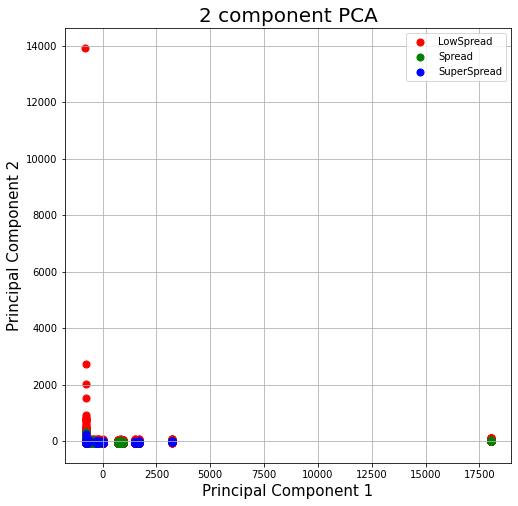

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LowSpread', 'Spread', 'SuperSpread']
targets2 = np.unique(y_train)
colors = ['r', 'g', 'b']
for target, color in zip(targets2,colors):
    print(target)
    indicesToKeep = finalDf['label_code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [22]:
#obtain the eigenpairs of the Wine covariance matrix:
#data_cov = np.dot(np.transpose(data.values),data.values)
#data_cov
X_train_cov = np.cov(X_train_std.T)
w, v = np.linalg.eig(X_train_cov)

In [23]:
#The percent of variability contained within each component
w_percent = (w/np.sum(w))*100                 
print(w, '-> eigenvalues')
print(w_percent, ' -> percent of variability explained')

[4.68190471 1.74653449 1.46032377 0.80300952 0.64539697 0.54509859
 0.37669832 0.0825042  0.27613096 0.23293532 0.15117495] -> eigenvalues
[42.55614759 15.87511586 13.27360507  7.29895067  5.86633225  4.95467068
  3.42399731  0.74992146  2.50989083  2.11726438  1.37410389]  -> percent of variability explained


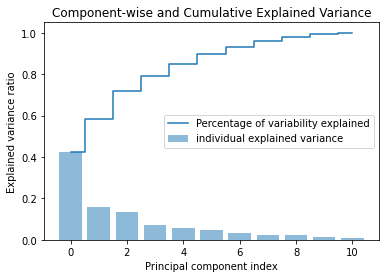

In [24]:
# calculate cumulative sum of explained variances
tot = sum(w)
var_exp = [(i / tot) for i in sorted(w, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.title("Component-wise and Cumulative Explained Variance")
plt.bar(range(0,11), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(0,11), cum_var_exp, where='mid',
         label='Percentage of variability explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [25]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(w[i]), v[:, i]) for i in range(len(w))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W2:\n', w2)

Matrix W2:
 [[ 0.39802686  0.07548609]
 [ 0.36806604  0.09620801]
 [ 0.21207444  0.10891566]
 [ 0.37897478  0.08480521]
 [ 0.34828846  0.07030567]
 [-0.39530182 -0.08205423]
 [ 0.33752331  0.0546998 ]
 [ 0.20123608 -0.66139603]
 [ 0.1330275  -0.7067886 ]
 [-0.21066697 -0.08990957]
 [ 0.15310568  0.07902472]]


In [26]:
X_train_pca = X_train_std.dot(w2)
print(X_train_pca)

[[ 1.02907231  0.50060721]
 [-1.17610228 -0.16989335]
 [ 2.36704187 -0.15435181]
 ...
 [-1.95580732 -0.42506671]
 [-1.43175017  0.1959066 ]
 [-0.56951383 -0.15928261]]


In [27]:
np.unique(y_train)
X_train_pca

array([[ 1.02907231,  0.50060721],
       [-1.17610228, -0.16989335],
       [ 2.36704187, -0.15435181],
       ...,
       [-1.95580732, -0.42506671],
       [-1.43175017,  0.1959066 ],
       [-0.56951383, -0.15928261]])

# 2.Load data - Maryland Inertia Data

In [28]:
CA_inertia_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_sd_inertia_labeledData_Sep17.csv',low_memory=False)
print(CA_inertia_labeled_data.shape)

(12296, 56)


In [29]:
CA_inertia_labeled_data.dtypes

Date                                           object
Province_State                                 object
FIPS                                            int64
New cases                                       int64
mask_rule_active                                int64
CTFIPS                                          int64
CTNAME                                         object
STFIPS                                          int64
Social distancing index                         int64
% staying home                                  int64
Trips/person                                  float64
% out-of-county trips                         float64
% out-of-state trips                          float64
Miles/person                                  float64
Work trips/person                             float64
Non-work trips/person                         float64
New COVID cases                                 int64
Population                                      int64
% change in consumption     

## Preprocessing data 

* drop na
* convert categorical code

In [30]:
CA_inertia_labeled_data['label_code'] = CA_inertia_labeled_data['label'].astype('category').cat.codes

CA_inertia_labeled_data.head(2)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,label_code
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0
1,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0


In [31]:
CA_inertia_labeled_data = CA_inertia_labeled_data.dropna()

In [32]:
CA_inertia_labeled_data[pd.isna(CA_inertia_labeled_data['label'])]

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,label_code


In [33]:
CA_inertia_labeled_data['label_code'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

In [34]:
CA_inertia_labeled_data['growth_code'] = CA_inertia_labeled_data['growth_label'].astype('category').cat.codes
CA_inertia_labeled_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,label_code,growth_code
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,1
1,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,1
2,2020-01-22,California,6039,0,0,6039,Madera County,6,18,17,3.55,29.7,0.1,39.9,0.52,3.03,0,157672,1.5,2020-01-22,0.45,19,52884,3.1,57.3,48.18,72,29,81,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,1
3,2020-01-22,California,6103,0,0,6103,Tehama County,6,18,19,3.47,30.1,1.9,50.6,0.55,2.93,0,63916,5.1,2020-01-22,0.33,26,42899,0.7,24.7,49.71,21,6,106,2.05,0.22,0.0,0.0,59,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,1
4,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,1


In [35]:
CA_inertia_labeled_data['growth_code'].unique()

array([1, 2, 3, 0], dtype=int8)

In [36]:
CA_inertia_labeled_data.dtypes

Date                                           object
Province_State                                 object
FIPS                                            int64
New cases                                       int64
mask_rule_active                                int64
CTFIPS                                          int64
CTNAME                                         object
STFIPS                                          int64
Social distancing index                         int64
% staying home                                  int64
Trips/person                                  float64
% out-of-county trips                         float64
% out-of-state trips                          float64
Miles/person                                  float64
Work trips/person                             float64
Non-work trips/person                         float64
New COVID cases                                 int64
Population                                      int64
% change in consumption     

In [37]:
CA_inertia_labeled_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'mask_rule_active',
       'CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
   

In [38]:
feature_labels = ['mask_rule_active','Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person','Non-work trips/person','% change in consumption',
       'Transit mode share','% people older than 60', 'Median income', '% African Americans', '% Hispanic Americans',
       '% Male', 'Population density','Employment density', '# hot spots/1000 people','Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people rank','% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate','% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity','Tests done/1000 people', '% ICU utilization', 'Ventilator shortage'
       ]

target_column = ['label_code']

X = CA_inertia_labeled_data[feature_labels]
y = CA_inertia_labeled_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Train Random Forest classifier

In [39]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


('mask_rule_active', 0.0046779757124752845)
('Social distancing index', 0.019429283721131917)
('% staying home', 0.018370906069028914)
('Trips/person', 0.02128267415154293)
('% out-of-county trips', 0.04344262415403291)
('% out-of-state trips', 0.02934294202207859)
('Miles/person', 0.02826989592978061)
('Work trips/person', 0.020498481322269148)
('Non-work trips/person', 0.022338588502385005)
('% change in consumption', 0.022757448023951576)
('Transit mode share', 0.04444429419307492)
('% people older than 60', 0.04250859121335983)
('Median income', 0.04436345486954704)
('% African Americans', 0.03276473716867501)
('% Hispanic Americans', 0.049785702148910184)
('% Male', 0.05301662606911807)
('Population density', 0.05143355350680487)
('Employment density', 0.05077159546854234)
('# hot spots/1000 people', 0.03626578608769184)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.042339842360402

In [40]:

#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)
print(X_train.shape)
# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(7352, 33)
('mask_rule_active', 0.005631300918691075)
('Social distancing index', 0.013586112257437789)
('% staying home', 0.012773980544647361)
('Trips/person', 0.014243660668561036)
('% out-of-county trips', 0.03834616864065094)
('% out-of-state trips', 0.02762249640476449)
('Miles/person', 0.02246491184203249)
('Work trips/person', 0.014076770918171633)
('Non-work trips/person', 0.015929068828691238)
('% change in consumption', 0.016839076746991817)
('Transit mode share', 0.04769183317732047)
('% people older than 60', 0.03851257352998927)
('Median income', 0.04594299624737143)
('% African Americans', 0.03212927579508459)
('% Hispanic Americans', 0.0468768086825594)
('% Male', 0.05222847928027471)
('Population density', 0.054504797574647205)
('Employment density', 0.05395864495475357)
('# hot spots/1000 people', 0.0345908845603549)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.038352

In [41]:
X_train.shape

(7352, 33)

## PCA Computation

In [42]:
print(len(feature_labels))

33


In [43]:
# split into training and testing datasets


X = CA_inertia_labeled_data[feature_labels].values
y = CA_inertia_labeled_data[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print(X_train)
print(y_train)

[[1.0000e+00 4.4000e+01 2.7000e+01 ... 1.1510e+02 2.1650e+01 6.7700e+02]
 [1.0000e+00 3.8000e+01 2.8000e+01 ... 2.0997e+02 2.3880e+01 1.1690e+03]
 [0.0000e+00 6.6000e+01 4.0000e+01 ... 6.1460e+01 1.4920e+01 5.7000e+02]
 ...
 [0.0000e+00 3.5000e+01 2.5000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 5.2000e+01 3.1000e+01 ... 1.5250e+01 1.7340e+01 6.5700e+02]
 [0.0000e+00 7.2000e+01 4.4000e+01 ... 6.5600e+00 1.7090e+01 6.6000e+02]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [44]:
# standardize the features
sc = ss()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [46]:
principalDf

,principal component 1,principal component 2
0,28302.319654,1057.801319
1,45885.232084,-1318.315048
2,-11434.938131,-53.079277
3,-21417.520176,173.025836
4,-9.170724,1862.338141
...,...,...
12249,-368.149574,-118.249366
12250,-11050.796609,-132.965676
12251,20031.062078,-753.626655
12252,20425.140796,-827.276356


In [47]:
finalDf = pd.concat([principalDf, CA_inertia_labeled_data[target_column]],axis=1 )
finalDf

,principal component 1,principal component 2,label_code
0,28302.319654,1057.801319,0.0
1,45885.232084,-1318.315048,0.0
2,-11434.938131,-53.079277,0.0
3,-21417.520176,173.025836,0.0
4,-9.170724,1862.338141,0.0
...,...,...,...
12291,NaN,NaN,0.0
12292,NaN,NaN,0.0
12293,NaN,NaN,0.0
12294,NaN,NaN,0.0


0
1
2


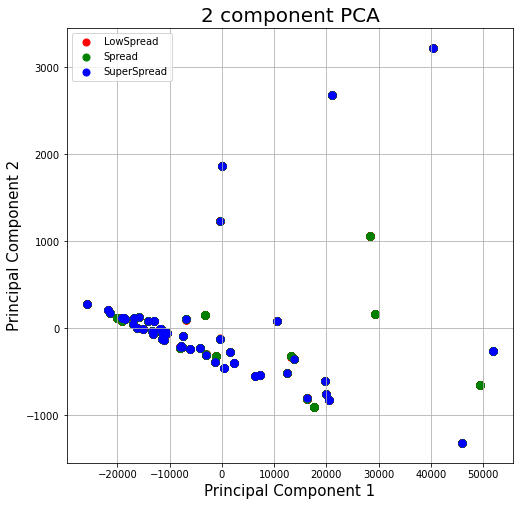

In [48]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LowSpread', 'Spread', 'SuperSpread']
targets2 = np.unique(y_train)
colors = ['r', 'g', 'b']
for target, color in zip(targets2,colors):
    print(target)
    indicesToKeep = finalDf['label_code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [49]:
#obtain the eigenpairs of the Wine covariance matrix:
#data_cov = np.dot(np.transpose(data.values),data.values)
#data_cov
X_train_cov = np.cov(X_train_std.T)
w, v = np.linalg.eig(X_train_cov)

In [50]:
#The percent of variability contained within each component
w_percent = (w/np.sum(w))*100                 
print(w, '-> eigenvalues')
print(w_percent, ' -> percent of variability explained')

[6.74145823e+00 5.75030096e+00 4.14188612e+00 3.03704005e+00
 1.63435905e+00 1.53175056e+00 1.18678274e+00 1.04036953e+00
 7.16557132e-01 6.50683554e-01 5.90176535e-01 5.20427323e-01
 4.50411362e-01 4.13690339e-01 3.56085335e-01 2.89448561e-01
 2.00449524e-01 1.95188381e-01 1.30501774e-01 1.07518871e-01
 8.30179027e-02 8.10024287e-02 5.49462840e-02 3.43888675e-02
 2.41858184e-02 6.18808182e-05 3.72144523e-03 1.76676324e-02
 8.65378556e-03 1.07661722e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00] -> eigenvalues
[2.24689075e+01 1.91654351e+01 1.38046774e+01 1.01222865e+01
 5.44722832e+00 5.10523992e+00 3.95548123e+00 3.46749411e+00
 2.38824529e+00 2.16869230e+00 1.96702575e+00 1.73455549e+00
 1.50119616e+00 1.37880702e+00 1.18681273e+00 9.64716046e-01
 6.68087180e-01 6.50552079e-01 4.34955197e-01 3.58354451e-01
 2.76694079e-01 2.69976615e-01 1.83132926e-01 1.14616194e-01
 8.06099953e-02 2.06245345e-04 1.24033711e-02 5.88852418e-02
 2.88425887e-02 3.58830566e-02 0.00000000e+00 0.00000

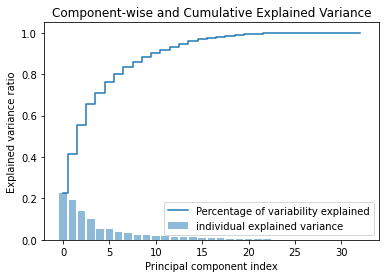

In [51]:
# calculate cumulative sum of explained variances
tot = sum(w)
var_exp = [(i / tot) for i in sorted(w, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.title("Component-wise and Cumulative Explained Variance")
plt.bar(range(0,33), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(0,33), cum_var_exp, where='mid',
         label='Percentage of variability explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [52]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(w[i]), v[:, i]) for i in range(len(w))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W2:\n', w2)

Matrix W2:
 [[ 0.20557639 -0.24887588]
 [ 0.24898512  0.27388662]
 [ 0.24306277  0.26782167]
 [-0.22526388 -0.2518293 ]
 [ 0.02510662 -0.07804775]
 [ 0.02226508 -0.03748149]
 [-0.04687539 -0.26387877]
 [-0.22820154 -0.01678148]
 [-0.17026964 -0.28020473]
 [-0.15977308 -0.2804346 ]
 [ 0.08819499  0.1693746 ]
 [ 0.00757221 -0.05984821]
 [ 0.0855534   0.16748428]
 [ 0.0176407   0.08005517]
 [-0.03967367 -0.01111284]
 [-0.01317277 -0.04341505]
 [ 0.08515242  0.18912137]
 [ 0.09038561  0.19208488]
 [ 0.06435948  0.0578587 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.0044419  -0.06506623]
 [ 0.22982818 -0.2702898 ]
 [ 0.19109433  0.14989808]
 [ 0.29677316 -0.16142289]
 [ 0.32643622 -0.02139502]
 [-0.01771375 -0.11489284]
 [ 0.29403112 -0.18949335]
 [ 0.12434153  0.13945553]
 [ 0.23690239 -0.27867175]
 [ 0.31588643 -0.1847491 ]
 [ 0.31160544 -0.20484769]]


In [53]:
X_train_pca = X_train_std.dot(w2)
print(X_train_pca)

[[ 1.45358628 -1.0303489 ]
 [ 3.5555724  -1.08924587]
 [ 3.96451167  2.57510508]
 ...
 [-3.32973673  0.96328197]
 [ 1.35756268  1.86474401]
 [ 3.59920626  4.80550456]]


In [54]:
np.unique(y_train)
X_train_pca

array([[ 1.45358628, -1.0303489 ],
       [ 3.5555724 , -1.08924587],
       [ 3.96451167,  2.57510508],
       ...,
       [-3.32973673,  0.96328197],
       [ 1.35756268,  1.86474401],
       [ 3.59920626,  4.80550456]])

# Selecting three counties in CA
* Los Angeles
* Riverside
* San Bernardino

### Filtered data for county - From Combined Dataset

In [55]:
Nassau_county_data = CA_labeled_data[CA_labeled_data['County Name'] == 'Los Angeles County']
Westchester_county_data = CA_labeled_data[CA_labeled_data['County Name'] == 'Riverside County']
Suffolk_county_data = CA_labeled_data[CA_labeled_data['County Name'] == 'San Bernardino County']

print(' Nassau county data ',Nassau_county_data.shape)
print(' Westchester county data ',Westchester_county_data.shape)
print(' Suffolk county data ',Suffolk_county_data.shape)

 Nassau county data  (172, 21)
 Westchester county data  (172, 21)
 Suffolk county data  (172, 21)


# Note about growth label

growth_code| label
----|----
 0 | drastic decrement
 1 | drastic growth
 2 | flat
 3 | mild decrement
 4 | mild increment





# Los Angeles County


In [58]:
feature_labels = ['retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index',
               'population_density','mask_rule_active']

target_column = ['label_code']

print(Nassau_county_data['growth_code'].unique())

Nassau_county_data_growth0 = Nassau_county_data[Nassau_county_data['growth_code'] == 0]
Nassau_county_data_growth1 = Nassau_county_data[Nassau_county_data['growth_code'] == 1]
Nassau_county_data_growth2 = Nassau_county_data[Nassau_county_data['growth_code'] == 2]
Nassau_county_data_growth3 = Nassau_county_data[Nassau_county_data['growth_code'] == 3]
Nassau_county_data_growth4 = Nassau_county_data[Nassau_county_data['growth_code'] == 4]

print(Nassau_county_data_growth0.shape)
print(Nassau_county_data_growth1.shape)
print(Nassau_county_data_growth2.shape)
print(Nassau_county_data_growth3.shape)
print(Nassau_county_data_growth4.shape)

[2 1 4 3 0]
(14, 21)
(14, 21)
(14, 21)
(14, 21)
(116, 21)


In [57]:
Nassau_county_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code,growth_code
38,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0,LessSpread,flat_growth,0,2
93,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0,LessSpread,flat_growth,0,2
115,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0,LessSpread,flat_growth,0,2
196,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0,LessSpread,flat_growth,0,2
267,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0,LessSpread,flat_growth,0,2


## 1.Drastic Decrement

In [73]:
from sklearn.ensemble import RandomForestRegressor
print("** Printing Los Angeles county data for drastic decrement ** ")

X = Nassau_county_data_growth0[feature_labels]
y = Nassau_county_data_growth0[target_column]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy',min_samples_leaf=5, n_jobs=-1)


# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

#print(sorted(zip(clf.feature_importances_, feature_labels), reverse=True))

** Printing Los Angeles county data for drastic decrement ** 
(14, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 2.Drastic Growth

In [59]:
print("** Printing Los Angeles county data for drastic growth ** ")

X = Nassau_county_data_growth1[feature_labels]
y = Nassau_county_data_growth1[target_column]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Nassay county data for drastic growth ** 
(14, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 3.Flat Growth

In [60]:
print("** Printing Los Angeles county data for flat growth ** ")

X = Nassau_county_data_growth2[feature_labels]
y = Nassau_county_data_growth2[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for flat growth ** 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 4.Mild Decrement

In [61]:
print("** Printing Los Angeles county data for mild decrement ** ")

X = Nassau_county_data_growth3[feature_labels]
y = Nassau_county_data_growth3[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for mild decrement ** 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 5.Mild Increment

In [62]:
print("** Printing Los Angeles county data for mild increment ** ")

X = Nassau_county_data_growth4[feature_labels]
y = Nassau_county_data_growth4[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for mild increment ** 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.06977419107960707)
('grocery and pharmacy', 0.08958726073268687)
('parks', 0.09709231830075055)
('transit stations', 0.12735764877310102)
('workplaces', 0.19437144913321447)
('residential', 0.1570366637876121)
('driving', 0.17475272615952686)
('m50', 0.05960071056892935)
('m50_index', 0.03026002731603643)
('population_density', 0.0)
('mask_rule_active', 0.0001670041485351708)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.06576386068986492)
('grocery and pharmacy', 0.0880660315867933)
('parks', 0.1202643696232466)
('transit stations', 0.15405773977092102)
('workplaces', 0.1633555823672173)
('residential', 0.1257757663975504)
('driving', 0.20123168213944198)
('m50', 0.05197989936984577)
('m50_index', 0.02931120620839816)
('population_density', 0.0)
('mask_rule_active', 0.0001938618467205205)


## Correlation map

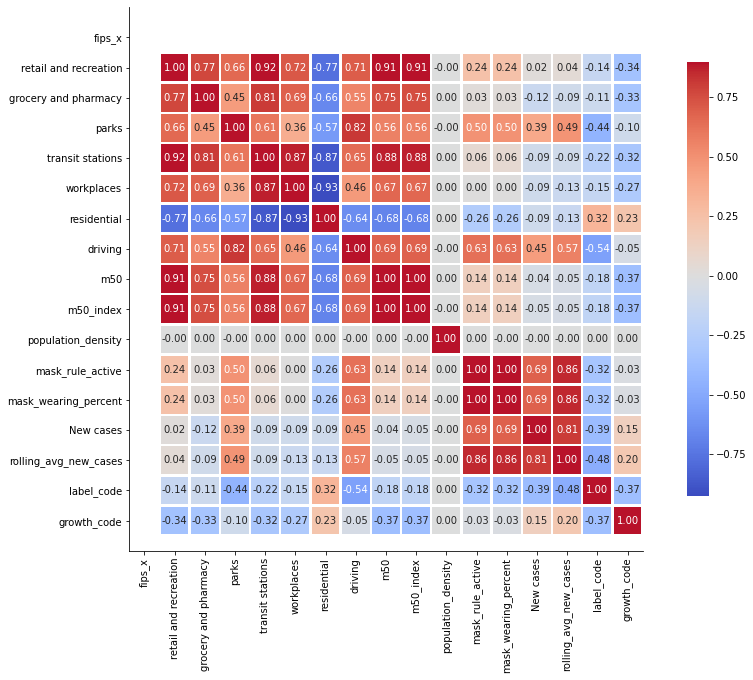

In [67]:


# Correlation

corr = Nassau_county_data.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

# Feature Importance: Using ExtraTreesClassifier

In [78]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE

## 1.CA Combined Data

In [87]:
CA_labeled_data_growth0 = CA_labeled_data[CA_labeled_data['growth_code'] == 0]
CA_labeled_data_growth1 = CA_labeled_data[CA_labeled_data['growth_code'] == 1]
CA_labeled_data_growth2 = CA_labeled_data[CA_labeled_data['growth_code'] == 2]
CA_labeled_data_growth3 = CA_labeled_data[CA_labeled_data['growth_code'] == 3]
CA_labeled_data_growth4 = CA_labeled_data[CA_labeled_data['growth_code'] == 4]

print(CA_labeled_data_growth0.shape)
print(CA_labeled_data_growth1.shape)
print(CA_labeled_data_growth2.shape)
print(CA_labeled_data_growth3.shape)
print(CA_labeled_data_growth4.shape)

(141, 21)
(126, 21)
(943, 21)
(3778, 21)
(4194, 21)


### 1.1 Label 0 : Drastic Decrement

In [88]:

print("** Printing CA all county data for Drastic Decrement ** ")
print(CA_labeled_data_growth0.shape)
X = CA_labeled_data_growth0[feature_labels]
y = CA_labeled_data_growth0[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)

print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Drastic Decrement ** 
(141, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0900793381695724)
('grocery and pharmacy', 0.05083941565113184)
('parks', 0.05414467212753291)
('transit stations', 0.07672226893084705)
('workplaces', 0.11222562571077538)
('residential', 0.07722558533153291)
('driving', 0.19332208872437218)
('m50', 0.06586434369839234)
('m50_index', 0.04459500314817932)
('population_density', 0.23002343477718215)
('mask_rule_active', 0.0049582237304814205)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.07564367522782155)
('grocery and pharmacy', 0.05547607126846462)
('parks', 0.04248854526387854)
('transit stations', 0.07857952022840667)
('workplaces', 0.09032848564075757)
('residential', 0.06640313529604994)
('driving', 0.18115578522338974)
('m50', 0.08316317239291356)
('m50_index', 0.044590950129606725)
('population_density', 0.2705358004096671)
('mask_rule_active', 0.011634858919044136)

Features with ranking:

retail and recreation 2
grocery and pharmacy 6
parks 3
transit stations 5
workplaces 4
residential 1
driving 1
m50 7
m50_index 8
population_density 1
mask_rule_active 9


### 1.2 Label 1 : Drastic Growth

In [89]:

print("** Printing CA all county data for Drastic Growth ** ")
print(CA_labeled_data_growth1.shape)
X = CA_labeled_data_growth1[feature_labels]
y = CA_labeled_data_growth1[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Drastic Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Drastic Growth ** 
(126, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

*****************************************
** Printing CA all county data for Drastic Growth ** 

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1


### 1.3 Label 2 : Flat Growth

In [90]:

print("** Printing CA all county data for Flat Growth ** ")
print(CA_labeled_data_growth2.shape)
X = CA_labeled_data_growth2[feature_labels]
y = CA_labeled_data_growth2[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Flat Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Flat Growth ** 
(943, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

*****************************************
** Printing CA all county data for Flat Growth ** 

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1


### 1.4 Label 3 : Mild Decrement

In [91]:

print("** Printing CA all county data for Mild Decrement ** ")
print(CA_labeled_data_growth3.shape)
X = CA_labeled_data_growth3[feature_labels]
y = CA_labeled_data_growth3[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Mild Decrement ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Mild Decrement ** 
(3778, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.08859607018644346)
('grocery and pharmacy', 0.10953169061260243)
('parks', 0.07890405889533626)
('transit stations', 0.08398622605168489)
('workplaces', 0.08446128825453446)
('residential', 0.0501996085342979)
('driving', 0.1546477859459921)
('m50', 0.0748110148448377)
('m50_index', 0.08066738758726164)
('population_density', 0.18806586920057516)
('mask_rule_active', 0.006128999886434055)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0745366117356443)
('grocery and pharmacy', 0.07924770843692332)
('parks', 0.06543839985862236)
('transit stations', 0.08144390578040808)
('workplaces', 0.05287749075871725)
('residential', 0.04492082166572745)
('driving', 0.2281784479416766)
('m50', 0.04836071167838866)
('m50_index', 0.057067392161992435)
('population_density', 0.24075212010048247)
('mask_rule_active', 0.027176389881417067)

*****************************************
** Printing CA all county data for Mild Decrement ** 

Features with ranking:

retail and recreation 1
grocery and pharmacy 2
parks 4
transit stations 3
workplaces 5
residential 8
driving 1
m50 7
m50_index 6
population_density 1
mask_rule_active 9


### 1.5 Label 4 : Mild Increment

In [92]:
print("** Printing CA all county data for Mild Increment ** ")
print(CA_labeled_data_growth4.shape)
X = CA_labeled_data_growth4[feature_labels]
y = CA_labeled_data_growth4[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Mild Increment ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Mild Increment ** 
(4194, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.1413502695745593)
('grocery and pharmacy', 0.08278671096075423)
('parks', 0.08013054643788468)
('transit stations', 0.06622946998005724)
('workplaces', 0.07808589098604934)
('residential', 0.06120163066184163)
('driving', 0.19570645789502605)
('m50', 0.08190706161831468)
('m50_index', 0.08063406408966486)
('population_density', 0.11096944230613957)
('mask_rule_active', 0.02099845548970855)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.1333484946471116)
('grocery and pharmacy', 0.07751065333805372)
('parks', 0.07915444142155824)
('transit stations', 0.06865213337351517)
('workplaces', 0.07102936797918591)
('residential', 0.05962838896305009)
('driving', 0.20225224565136593)
('m50', 0.07527253886055622)
('m50_index', 0.07169029085919056)
('population_density', 0.12514165035684036)
('mask_rule_active', 0.03631979454957221)

*****************************************
** Printing CA all county data for Mild Increment ** 

Features with ranking:

retail and recreation 1
grocery and pharmacy 3
parks 4
transit stations 6
workplaces 2
residential 8
driving 1
m50 7
m50_index 5
population_density 1
mask_rule_active 9


## 2.CA Maryland Inertia Data

In [102]:
CA_inertia_labeled_data_growth0 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 0]
CA_inertia_labeled_data_growth1 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 1]
CA_inertia_labeled_data_growth2 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 2]
CA_inertia_labeled_data_growth3 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 3]
CA_inertia_labeled_data_growth4 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 4]

print(CA_inertia_labeled_data_growth0.shape)
print(CA_inertia_labeled_data_growth1.shape)
print(CA_inertia_labeled_data_growth2.shape)
print(CA_inertia_labeled_data_growth3.shape)
print(CA_inertia_labeled_data_growth4.shape)

(14, 58)
(3102, 58)
(4513, 58)
(4625, 58)
(0, 58)


In [103]:
inertia_feature_labels = [ 'mask_rule_active',
         'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person',  'Population',
       '% change in consumption', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage']

inertia_target_column = ['label_code']

### 2.1 Label 0 : Drastic Decrement

In [104]:

print("** Printing CA inertia all county data for Drastic Decrement ** ")
print(CA_inertia_labeled_data_growth0.shape)
X = CA_inertia_labeled_data_growth0[inertia_feature_labels]
y = CA_inertia_labeled_data_growth0[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)

print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA inertia all county data for Drastic Decrement ** 
(14, 58)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

### 2.2 Label 1 : Drastic Growth

In [105]:

print("** Printing CA_inertia all county data for Drastic Growth ** ")
print(CA_inertia_labeled_data_growth1.shape)
X = CA_inertia_labeled_data_growth1[inertia_feature_labels]
y = CA_inertia_labeled_data_growth1[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Drastic Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Drastic Growth ** 
(3102, 58)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

### 2.3 Label 2 : Flat Growth

In [107]:

print("** Printing CA_inertia all county data for Flat Growth ** ")
print(CA_inertia_labeled_data_growth2.shape)
X = CA_inertia_labeled_data_growth2[inertia_feature_labels]
y = CA_inertia_labeled_data_growth2[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Flat Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Flat Growth ** 
(4513, 58)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0012130740210201123)
('Social distancing index', 0.018364267733551123)
('% staying home', 0.019245600994670622)
('Trips/person', 0.011285198442720641)
('% out-of-county trips', 0.02703660711301627)
('% out-of-state trips', 0.016058614378618753)
('Miles/person', 0.013662805088747728)
('Work trips/person', 0.010919412564095678)
('Non-work trips/person', 0.011375705104120589)
('Population', 0.038371257721681165)
('% change in consumption', 0.016562158722116024)
('Transit mode share', 0.03648738106144143)
('% people older than 60', 0.044883762024052705)
('Median income', 0.03187328475528982)
('% African Americans', 0.041550420621485694)
('% Hispanic Americans', 0.05247833766350958)
('% Male', 0.08726981665374065)
('Population density', 0.041793918778750404)
('Employment density', 0.04243656306147771)
('# hot spots/1000 people', 0.04920378662690079)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.004950098355411349)
('Social distancing index', 0.016220608589560148)
('% staying home', 0.014035044033775838)
('Trips/person', 0.0063345703548415054)
('% out-of-county trips', 0.01796993286599509)
('% out-of-state trips', 0.01274942433359056)
('Miles/person', 0.009623296022923021)
('Work trips/person', 0.005959220232892642)
('Non-work trips/person', 0.007916538791697207)
('Population', 0.02970960014526397)
('% change in consumption', 0.015042290332226739)
('Transit mode share', 0.02955597788208887)
('% people older than 60', 0.03644197516174981)
('Median income', 0.023781950294863796)
('% African Americans', 0.02837067904015789)
('% Hispanic Americans', 0.03712421737509074)
('% Male', 0.06008516916127611)
('Population density', 0.03416997489616335)
('Employment density', 0.03792173207799789)
('# hot spots/1000 people', 0.031485223881981404)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tra

### 2.4 Label 3 : Mild Decrement

In [108]:

print("** Printing CA_inertia all county data for Mild Decrement ** ")
print(CA_inertia_labeled_data_growth3.shape)
X = CA_inertia_labeled_data_growth3[inertia_feature_labels]
y = CA_inertia_labeled_data_growth3[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Mild Decrement ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Mild Decrement ** 
(4625, 58)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.006681068121096966)
('Social distancing index', 0.012905421088340044)
('% staying home', 0.011516220283729983)
('Trips/person', 0.012824299208278843)
('% out-of-county trips', 0.0334479013153414)
('% out-of-state trips', 0.029116410629325466)
('Miles/person', 0.025257952684170432)
('Work trips/person', 0.014731346272340101)
('Non-work trips/person', 0.013585073902447875)
('Population', 0.04462580690386364)
('% change in consumption', 0.015102856242382423)
('Transit mode share', 0.04258480919284306)
('% people older than 60', 0.032957429561322776)
('Median income', 0.03654427920332501)
('% African Americans', 0.029855694909708717)
('% Hispanic Americans', 0.035104816195397646)
('% Male', 0.03728875454444808)
('Population density', 0.04159943532626643)
('Employment density', 0.04037415647117183)
('# hot spots/1000 people', 0.03685714071708172)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tra

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.007574421882783021)
('Social distancing index', 0.010399285456331592)
('% staying home', 0.00882887509599081)
('Trips/person', 0.009395245256420728)
('% out-of-county trips', 0.030933740588160372)
('% out-of-state trips', 0.0279151642376532)
('Miles/person', 0.020738713081216092)
('Work trips/person', 0.010632713418482194)
('Non-work trips/person', 0.010560575519034616)
('Population', 0.04620811352982778)
('% change in consumption', 0.011397356867160114)
('Transit mode share', 0.04210350199885168)
('% people older than 60', 0.03137820038514557)
('Median income', 0.03643744461338941)
('% African Americans', 0.03131690954246489)
('% Hispanic Americans', 0.03481549515265411)
('% Male', 0.04315296126003624)
('Population density', 0.04346980689467577)
('Employment density', 0.042852875677189005)
('# hot spots/1000 people', 0.03528743522685633)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracin

### 2.5 Label 4 : Mild Increment -No data, need to check labeling

In [109]:
print("** Printing CA_inertia all county data for Mild Increment ** ")
print(CA_inertia_labeled_data_growth4.shape)
X = CA_inertia_labeled_data_growth4[inertia_feature_labels]
y = CA_inertia_labeled_data_growth4[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Mild Increment ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Mild Increment ** 
(0, 58)


ValueError: ignored